In [1]:
import numpy as np
import matplotlib as plt
from PIL import Image
import os
import glob
import scipy.io
import time
from utils import *


folder = './real_data/lines/'
elliptical_pupil = True                 # Whether to use 0.55 elliptical pupil or 0.33 circular pupil
pre_process = False                      # Preprocess the data by applying spectrum support and filtering
equalization = False                    # Enable for real data
wfe_correction = False                  # k-illumination correction
wfe_alpha = 0.1
data_format = 'npz'                     # 'npz' 'mat' 'img'
save_mat = True
keyword = 'CD60eb'
# index_to_exclude = [19, 20]
index_to_exclude = [14, 15]

roi_size_px = 332*2
use_ROI = True
ROI_length = 332
ROI_center =  [int(roi_size_px/2), int(roi_size_px/2)]
init_option = 'plane'                   # 'zernike' 'plane' 'file'
file_name = f'{folder}gt_abe.npy'

recon_init = True
recon_alg = 'GN'
iters = 1000
spectrum_lr = 1e-3
lens_lr = 0
swap_dim = False

#%% Set up parameters
# wavelength of acquisition
lambda_m = 13.5e-9

if elliptical_pupil:
    dx_m = 10.8e-9
else:
    dx_m = 15e-9
# effective field size
Dx_m = roi_size_px * dx_m

# spatial scales
x_m = np.arange(1, roi_size_px + 1) * dx_m
y_m = np.arange(1, roi_size_px + 1) * dx_m

# angular frequency scale
fs = 1 / (x_m[1] - x_m[0])
Nfft = len(x_m)
df = fs / Nfft
freq_cpm = np.arange(0, fs, df) - (fs - Nfft % 2 * df) / 2
Fx, Fy = np.meshgrid(freq_cpm, freq_cpm)

if elliptical_pupil:
    fc_lens = (np.arcsin(.55/4)/lambda_m)
    a = fc_lens  # semi-major axis
    b = fc_lens / 2  # semi-minor axis
    FILTER = ((Fx/a)**2 + (Fy/b)**2) <= 1

    # # Take 20% obscuration into account
    a_ob = a*0.2
    b_ob = b*0.2
    FILTER[(Fx/a_ob)**2 + (Fy/b_ob)**2 <= 1] = 0
else:
    fc_lens = (np.arcsin(.33/4)/lambda_m)
    FILTER = (Fx**2 + Fy**2) <= fc_lens**2


#%% Load data
if data_format == 'img':
    # Find all .png files in the folder
    files = glob.glob(os.path.join(folder, f"{keyword}_sx*.png"))
    img = []
    sx = []
    sy = []

    for filename in files:
        img_0 = np.array(Image.open(filename)).astype(float)
        img.append(img_0)
        filename = os.path.basename(filename)
        sx_0 = float(filename[-17:-12])
        # sx_0 = float(filename[-20:-15])
        sy_0 = float(filename[-9:-4])
        sx.append(sx_0)
        sy.append(sy_0)

elif data_format == 'mat':
    path = folder + keyword + '.mat'
    data = scipy.io.loadmat(path)
    img = data['I_low']
    img = [img[:,:,i] for i in range(img.shape[2])]
    na_calib = data['na_calib']
    na_calib = na_calib/(fc_lens*lambda_m)
    sx = [na_calib[i, 0] for i in range(na_calib.shape[0])]
    sy = [na_calib[i, 1] for i in range(na_calib.shape[0])]
    
elif data_format == 'npz':
    path = folder + keyword + '.npz'
    data = np.load(path)
    img = data['imgs']
    img = [img[i,:,:] for i in range(img.shape[0])]
    sx = data['sx']
    sy = data['sy']
    
if index_to_exclude is not None:
    img = [img[i] for i in range(len(img)) if i+1 not in index_to_exclude]
    sx = [sx[i] for i in range(len(sx)) if i+1 not in index_to_exclude]
    sy = [sy[i] for i in range(len(sy)) if i+1 not in index_to_exclude]

print(f"Reconstructing with {len(img)} images")
    
if pre_process:
    binaryMask = (Fx**2 + Fy**2) <= (2*fc_lens)**2
    
    # Taper the edge to avoid ringing effect
    from scipy.ndimage import gaussian_filter
    xsize, ysize = img[0].shape[:2]
    edgeMask = np.zeros((xsize, ysize))
    pixelEdge = 3
    edgeMask[0:pixelEdge, :] = 1
    edgeMask[-pixelEdge:, :] = 1
    edgeMask[:, 0:pixelEdge] = 1
    edgeMask[:, -pixelEdge:] = 1
    edgeMask = gaussian_filter(edgeMask, sigma=5)
    maxEdge = np.max(edgeMask)
    edgeMask = (maxEdge - edgeMask) / maxEdge


    for i in range(len(img)):
        ftTemp = ft(img[i])
        noiseLevel = max(np.finfo(float).eps, np.mean(np.abs(ftTemp[~binaryMask])))
        ftTemp = ftTemp * np.abs(ftTemp) / (np.abs(ftTemp) + noiseLevel)
        img[i] = ift(ftTemp * binaryMask) * edgeMask

    
if equalization:
    # Equalize each patch
    patch_size = 332
    for im in img:
        # calculate the energy of central patch
        cen_energy = np.sum(img[0][patch_size: 2*patch_size, patch_size: 2*patch_size])
        # equalize the energy of all patches
        for i in range(3):
            for j in range(3):
                im[i*patch_size: (i+1)*patch_size, j*patch_size: (j+1)*patch_size] *= cen_energy / np.sum(
                    im[i*patch_size: (i+1)*patch_size, j*patch_size: (j+1)*patch_size])
    # Equalize the energy of all images
    energy = np.sum(img[0])
    for im in img:
        im *= energy / np.sum(im)

if wfe_correction:
    sx = np.array(sx)
    sy = np.array(sy)
    kx = sx * fc_lens
    ky = sy * fc_lens
    k = 1 / lambda_m
    kz = np.sqrt(k**2 - kx**2 - ky**2)
    phi = np.arccos(kz / k)

    xc_m = (ROI_center[0]-int(roi_size_px/2))*dx_m
    yc_m = (ROI_center[1]-int(roi_size_px/2))*dx_m
    r_m = np.sqrt(xc_m**2 + yc_m**2)
    delta_phi = 2*8*lambda_m/((10*1e-6)**2)*r_m
            
    delta_sx = delta_phi/(fc_lens*lambda_m)*yc_m/r_m
    delta_sy = delta_phi/(fc_lens*lambda_m)*xc_m/r_m
    sx_corrected = sx + wfe_alpha * delta_sx
    sy_corrected = sy + wfe_alpha * delta_sy

    sx, sy = sx_corrected, sy_corrected


#%% Crop ROI
if use_ROI:
    print(f'Using ROI of size {ROI_length}')
    x_m = x_m[ROI_center[0]-int(ROI_length/2):ROI_center[0]+int(ROI_length/2)]
    y_m = y_m[ROI_center[1]-int(ROI_length/2):ROI_center[1]+int(ROI_length/2)]
    img = [i[ROI_center[0]-int(ROI_length/2):ROI_center[0]+int(ROI_length/2), 
             ROI_center[1]-int(ROI_length/2):ROI_center[1]+int(ROI_length/2)] for i in img]
    if elliptical_pupil:
        a = fc_lens  # semi-major axis
        b = fc_lens / 2  # semi-minor axis
        X_full = [sx*a*Dx_m for sx in sx]
        Y_full = [sy*b*Dx_m for sy in sy]
    else:
        X_full = [sx*fc_lens*Dx_m for sx in sx]
        Y_full = [sy*fc_lens*Dx_m for sy in sy]
    X = [int(x/roi_size_px*ROI_length) for x in X_full]
    Y = [int(y/roi_size_px*ROI_length) for y in Y_full]
     
    roi_size_px = min(ROI_length, roi_size_px)
    Dx_m = ROI_length * dx_m
    Nfft = len(x_m)
    df = fs / Nfft
    freq_cpm = np.arange(0, fs, df) - (fs - Nfft % 2 * df) / 2
    Fx, Fy = np.meshgrid(freq_cpm, freq_cpm)
    if elliptical_pupil:
        fc_lens = (np.arcsin(.55/4)/lambda_m)
        a = fc_lens
        b = fc_lens / 2
        FILTER = ((Fx/a)**2 + (Fy/b)**2) <= 1
        a_ob = a*0.2
        b_ob = b*0.2
        FILTER[(Fx/a_ob)**2 + (Fy/b_ob)**2 <= 1] = 0
    else:
        fc_lens = (np.arcsin(.33/4)/lambda_m)
        FILTER = (Fx**2 + Fy**2) <= fc_lens**2
else:
    if elliptical_pupil:
        a = fc_lens
        b = fc_lens / 2
        X = [int(x*a*Dx_m) for x in sx]
        Y = [int(y*b*Dx_m) for y in sy]
    else:
        X = [int(x*fc_lens*Dx_m) for x in sx]
        Y = [int(y*fc_lens*Dx_m) for y in sy]


if swap_dim:
    X, Y = Y, X

lens_init = get_lens_init(FILTER, init_option, file_name)
spectrum_guess = ft(np.sqrt(img[0]))
object_guess = ift(spectrum_guess)
lens_guess = np.complex128(lens_init)

meas = np.array(img)
print(meas.shape)
print(meas.min(), meas.max())

Reconstructing with 38 images
Using ROI of size 332
(38, 332, 332)
581.0 3329.0


In [2]:
if recon_init:
    def load_recon(folder, recon_alg, downsample=False):
        if recon_alg == 'APIC':
            filename = f'{folder}result/{keyword}_APIC_{str(roi_size_px)}.mat'
            recon = scipy.io.loadmat(filename)
            object_guess = recon['himMatching']
            pupil_recon = recon['CTF_abe']
            pupil_recon = np.fliplr(pupil_recon)
            pupil_recon = np.flipud(pupil_recon)
        else:
            object_guess = np.load(f'{folder}/result/{keyword}_{recon_alg}_recon.npy')
            pupil_recon = np.load(f'{folder}/result/{keyword}_{recon_alg}_abe.npy')

        if downsample:        
            if recon_alg == 'GN' or recon_alg == 'APIC':
                downsampled_size = roi_size_px
                size_px = object_guess.shape[0]
                object_guess = ft(object_guess)
                object_guess = object_guess[size_px//2-downsampled_size//2:size_px//2+downsampled_size//2, size_px//2-downsampled_size//2:size_px//2+downsampled_size//2]
                object_guess = ift(object_guess)
        
        return object_guess, pupil_recon
    
    object_guess, pupil_recon = load_recon(folder, recon_alg, downsample=True)
    spectrum_guess = ft(object_guess)
    # lens_guess = pupil_recon
    
    

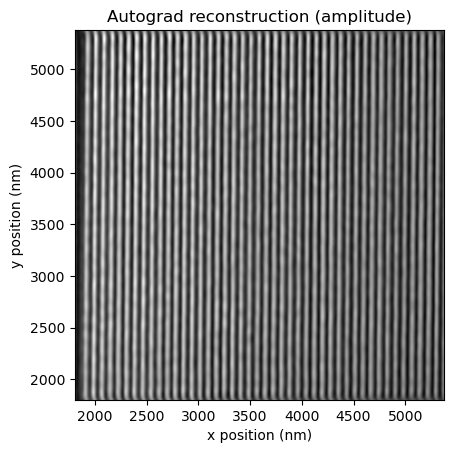

<Figure size 640x480 with 0 Axes>

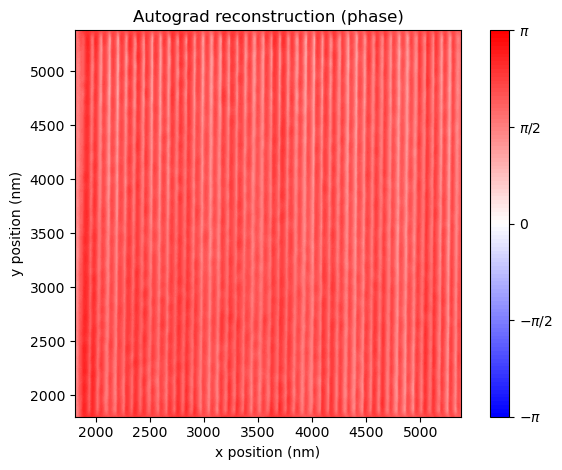

853.400390625


In [3]:
import torch
from tqdm.notebook import tqdm

# use gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# normalization
# meas = np.float32(meas)
# meas = meas / np.max(meas)
# spectrum_guess = ft(np.sqrt(meas[0]))

# convert to tensor
spectrum_tensor = torch.tensor(spectrum_guess, dtype=torch.complex64, requires_grad=True, device=device)
lens_tensor = torch.tensor(lens_guess, dtype=torch.complex64, requires_grad=True, device=device)
meas_tensor = torch.tensor(meas, dtype=torch.float32, device=device)
FILTER_tensor = torch.tensor(FILTER, dtype=torch.float32, device=device)

# circular shift (2D)
circshift2_torch = lambda x, sx, sy: torch.roll(
    torch.roll(x, int(round(sx)), dims=1),
    int(round(sy)), dims=0
)

# centered 2D Fourier Transform
ft_torch = lambda s: torch.fft.fftshift(
    torch.fft.fft2(
        torch.fft.ifftshift(s, dim=(-2, -1)),
        dim=(-2, -1)
    ), dim=(-2, -1)
)

# centered 2D Inverse Fourier Transform
ift_torch = lambda s: torch.fft.fftshift(
    torch.fft.ifft2(
        torch.fft.ifftshift(s, dim=(-2, -1)),
        dim=(-2, -1)
    ), dim=(-2, -1)
)

def FP_forward(spectrum_guess, lens_guess, X, Y, meas_tensor):
    pred = torch.zeros_like(meas_tensor, device=device)
    for idx in range(len(X)):
        shifted_spectrum = circshift2_torch(spectrum_guess, -X[idx], -Y[idx])
        pred[idx] = torch.abs(ift_torch(shifted_spectrum * lens_guess))
    return pred


def plot_recon(spectrum_tensor):
    spectrum_recon = spectrum_tensor.detach().cpu().numpy()
    object_recon = ift(spectrum_recon)
    plt.figure(1)
    plt.imshow(np.abs(object_recon), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9], cmap='gray')
    plt.xlabel('x position (nm)')
    plt.ylabel('y position (nm)')
    plt.title('Autograd reconstruction (amplitude)')
    plt.show()


    plt.figure(2)
    # Define custom colormap: Blue -> White -> Red
    colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_diverging', colors, N=100)
    fig, ax = plt.subplots()
    # Plot the phase of object_guess
    cax = ax.imshow(
        np.angle(object_recon),
        extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9],
        cmap=cmap, vmin=-np.pi, vmax=np.pi
    )
    ax.set_xlabel('x position (nm)')
    ax.set_ylabel('y position (nm)')
    ax.set_title('Autograd reconstruction (phase)')
    cbar = fig.colorbar(cax, ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    cbar.ax.set_yticklabels(['$-\pi$', '$-\pi/2$', '$0$', '$\pi/2$', '$\pi$'])
    plt.tight_layout()
    plt.show()

def first_order_gradient_loss(pred_tensor, meas_tensor):
    """
    Compute MSE between the first-order (x and y) gradients of
    pred_tensor and sqrt(meas_tensor).
    """
    sqrt_meas = torch.sqrt(meas_tensor)

    # x-gradients (shift along width)
    dx_pred = pred_tensor[..., :, 1:] - pred_tensor[..., :, :-1]
    dx_meas = sqrt_meas[..., :, 1:] - sqrt_meas[..., :, :-1]

    # y-gradients (shift along height)
    dy_pred = pred_tensor[..., 1:, :] - pred_tensor[..., :-1, :]
    dy_meas = sqrt_meas[..., 1:, :] - sqrt_meas[..., :-1, :]

    loss_dx = torch.mean((dx_pred - dx_meas) ** 2)
    loss_dy = torch.mean((dy_pred - dy_meas) ** 2)

    return (loss_dx + loss_dy) * 0.5
    
plot_recon(spectrum_tensor)

init_pred = FP_forward(spectrum_tensor, lens_tensor, X, Y, meas_tensor)
init_loss = torch.mean((init_pred - torch.sqrt(meas_tensor))**2)
print(init_loss.item())


  0%|          | 0/1000 [00:00<?, ?it/s]

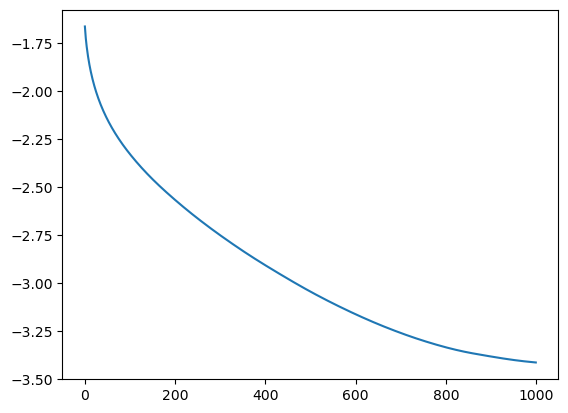

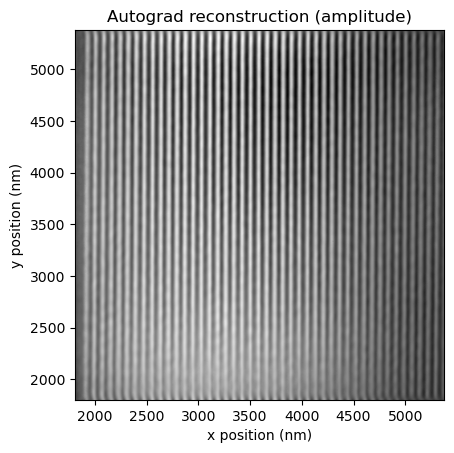

<Figure size 640x480 with 0 Axes>

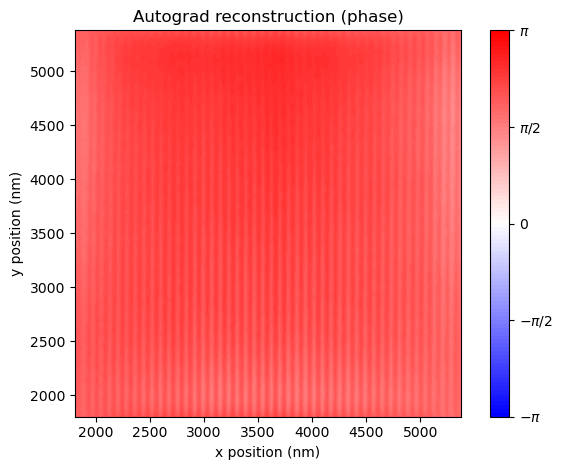

In [4]:
iters = 1000
spectrum_lr = 1e2
lens_lr = 0 #1
loss_type = 'feature'       # 'feature' 'amplitude' 'intensity'


optimizer_spectrum = torch.optim.RMSprop([spectrum_tensor], lr=spectrum_lr)
optimizer_lens = torch.optim.Adam([lens_tensor], lr=lens_lr)


losses = []
for i in tqdm(range(iters)):
    optimizer_spectrum.zero_grad()
    optimizer_lens.zero_grad()
    pred_tensor = FP_forward(spectrum_tensor, lens_tensor, X, Y, meas_tensor)
    if loss_type == 'feature':
        loss = first_order_gradient_loss(pred_tensor, torch.sqrt(meas_tensor))
    elif loss_type == 'amplitude':
        loss = torch.mean((pred_tensor - torch.sqrt(meas_tensor))**2)
    elif loss_type == 'intensity':
        loss = torch.mean((pred_tensor**2 - meas_tensor)**2)
    else:
        raise ValueError('Invalid loss type')
    
    loss.backward()
    optimizer_spectrum.step()
    optimizer_lens.step()
    with torch.no_grad():
        lens_tensor = lens_tensor * FILTER_tensor
    losses.append(loss.item())

plt.figure()    
plt.plot(np.log(losses))
plt.show()

plot_recon(spectrum_tensor)



In [5]:
print(losses[0])
print(losses[-1])

amplitude_loss = torch.mean((pred_tensor - torch.sqrt(meas_tensor))**2)
feature_loss = first_order_gradient_loss(pred_tensor, torch.sqrt(meas_tensor))
print('Amplitude loss:', amplitude_loss.item())
print('Feature loss:', feature_loss.item())

0.1891786754131317
0.03285833075642586
Amplitude loss: 837.4926147460938
Feature loss: 0.03285833075642586


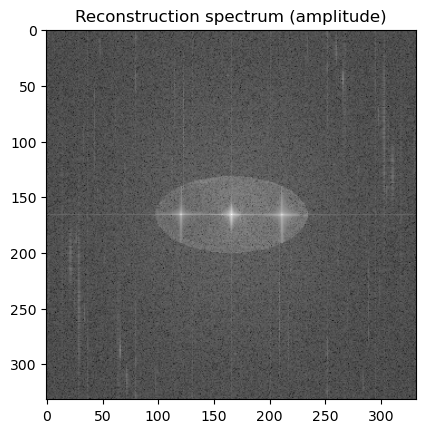

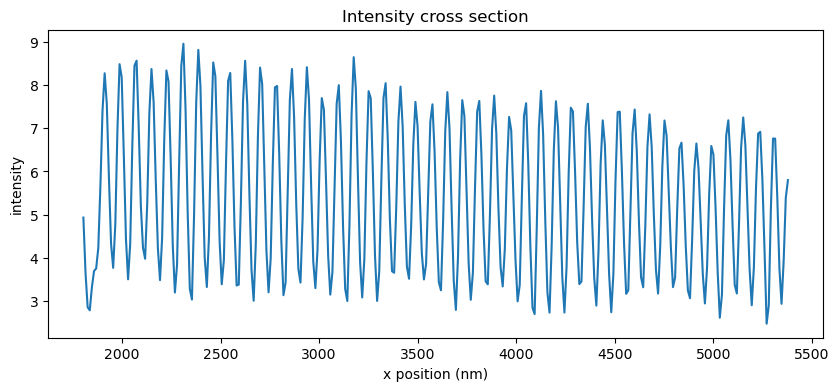

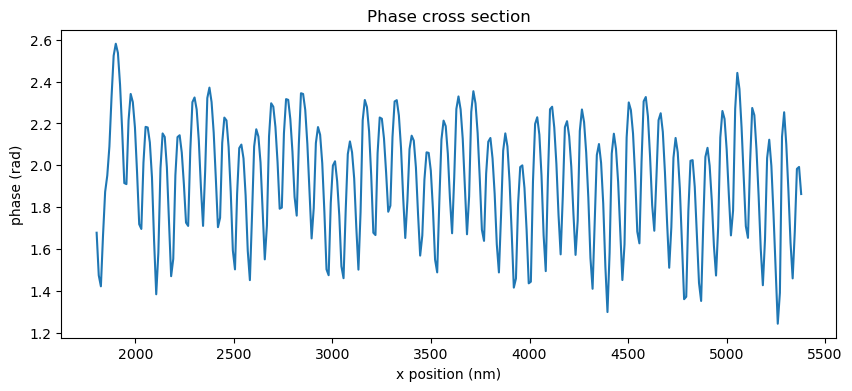

In [6]:
# show the intensity of the recon spectrum
plt.figure()
spectrum_recon = spectrum_tensor.detach().cpu().numpy()
object_recon = ift(spectrum_recon)
plt.imshow(np.log(np.abs(ft(object_recon)+1)), cmap='gray')
plt.title('Reconstruction spectrum (amplitude)')
plt.show()

# show a cross section of the intensity and phase
x_vals = np.linspace(x_m[0]*1e9, x_m[-1]*1e9, object_guess.shape[1])
plt.figure(3, figsize=(10, 4))
plt.plot(x_vals, np.abs(object_guess)[roi_size_px//2, :])
plt.xlabel('x position (nm)')
plt.ylabel('intensity')
plt.title('Intensity cross section')
plt.show()

plt.figure(4, figsize=(10, 4))
plt.plot(x_vals, np.angle(object_guess)[roi_size_px//2, :])
plt.xlabel('x position (nm)')
plt.ylabel('phase (rad)')
plt.title('Phase cross section')
plt.show()

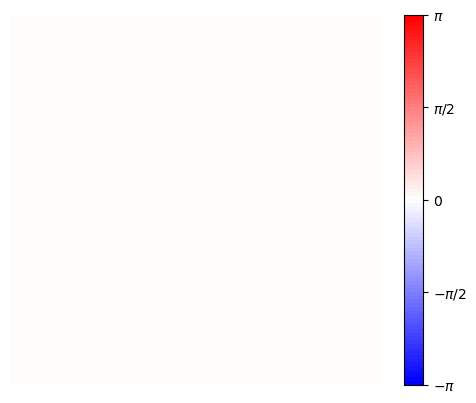

In [7]:
def show_phase(phase):
    # color map
    colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # R -> W -> B
    cmap_name = 'custom_diverging'
    cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
    
    # crop center region
    range = 150
    size = phase.shape[0]
    img = phase[size//2-range:size//2+range, size//2-range:size//2+range]

    fig, ax = plt.subplots()
    cax = ax.imshow(img, cmap=cm, vmin=-np.pi, vmax=np.pi)  # Adjust the limits to -pi to pi for your use case
    plt.axis('off')
    
    # Create colorbar
    cbar = fig.colorbar(cax, ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    cbar.ax.set_yticklabels(['$-\pi$', '$-\pi/2$', '$0$', '$\pi/2$', '$\pi$']) 
    
    plt.show()

lens_recon = lens_tensor.detach().cpu().numpy()
show_phase(np.angle(lens_recon)*FILTER)